In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Utils

In [74]:
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Check the img_path variable")
    return img

def show_img(img, title="Original Image", axis=False):
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.imshow(img, cmap='gray')

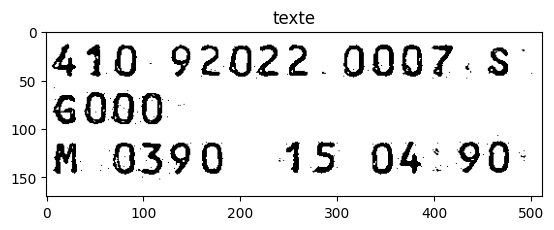

In [75]:
img_path = "img/texte.bmp"
img = read_img(img_path)

show_img(img, title="texte", axis=True)

# Profile of a Gray level image

In [76]:
def profile(img, offset, axis='H'):
    assert axis == "H" or axis == "V", "axis must be either 'H' or 'V'"
    assert offset >= 0, "The offset must be positive"
    if axis == "H":
        assert offset < img.shape[0], "the offset of a horizental profile\
            can't be greater than the number of rows of the image"
        
        return img[offset, :]
    else:
        assert offset < img.shape[1], "the offset of a vertical profile\
            can't be greater than the number of columns of the image"
        
        return img[:, offset]

def plot_profile(img, offset, axis='H'):
    profile_ = profile(img, offset, axis)
    plt.figure()
    axis_name = "Horizental" if axis=="H" else "Vertical"
    plt.title(axis_name + f" Profile at {offset}")
    plt.ylabel("NdG")
    plt.plot(range(len(profile_)), profile_)

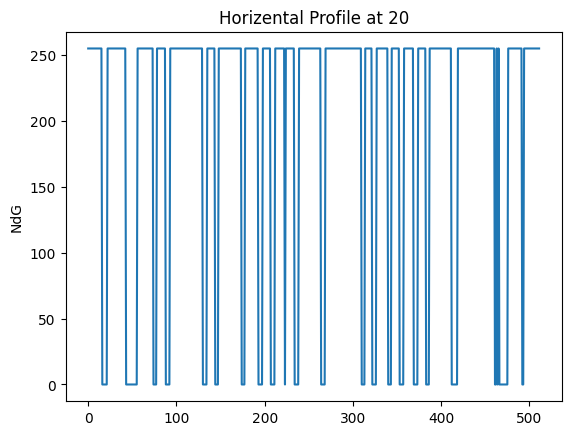

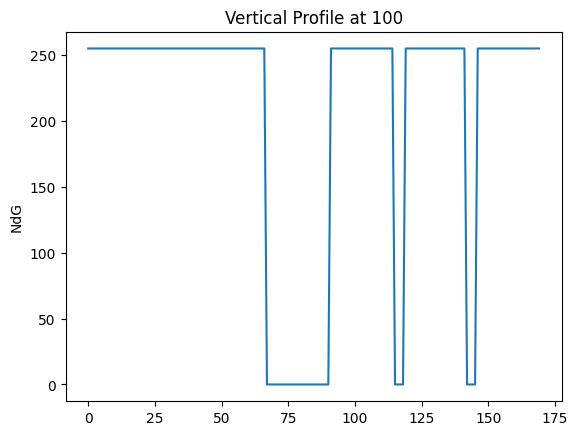

In [77]:
plot_profile(img, 20)
plot_profile(img, 100, "V")

# Projection of a Gray level image

In [78]:
def projection(img, offset, axis='H'):
    return profile(img, offset, axis).sum()

def plot_projection(img, axis='H'):
    axe = 0 if axis=='H' else 1
    proj = [projection(img, offset, axis) \
            for offset in range(img.shape[axe])]
    
    plt.figure()
    axis_name = "Horizental" if axis=="H" else "Vertical"
    plt.title(axis_name + f" Projection")
    plt.ylabel("NdG")
    plt.plot(range(len(proj)), proj)

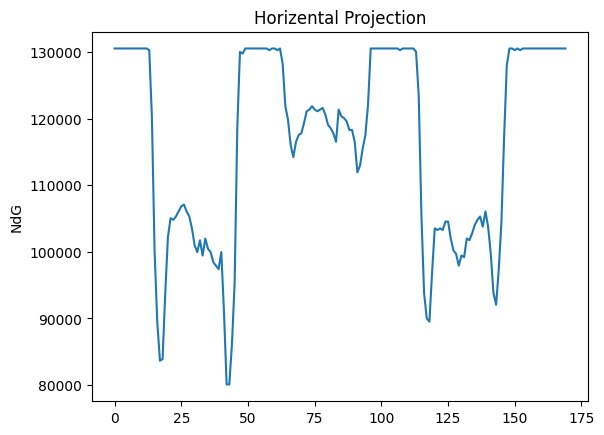

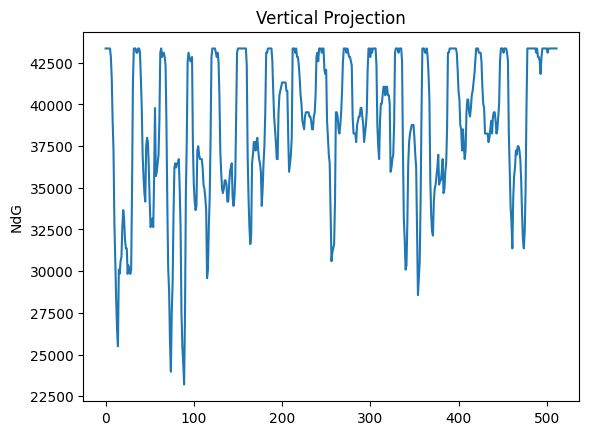

In [79]:
plot_projection(img)
plot_projection(img, "V")

# Histogram

In [80]:
def histogram(img, normal=False, cumulative=False):
    img_int = img.astype(int)
    intensities, counts_ = np.unique(img_int, return_counts=True)
    counts = np.zeros(256)
    counts[intensities] = counts_
    if normal:
        counts = counts/img_int.size

    if cumulative:
        counts = np.cumsum(counts)   

    return intensities, counts     

def plot_hist(img, normal=False, cumulative=False, title="Histogram"):
    _, counts = histogram(img, normal, cumulative)
    plt.title(title), plt.xlabel("NdG"), plt.ylabel("#NdG")
    plt.bar(range(256), counts)    

In [81]:
def hist_stretch(img, bornes='minmax'):
    assert bornes == "minmax" or bornes == "percentilles", \
        "axis must be either 'minmax' or 'percentilles'"
    
    if bornes == 'minmax':
        inf = img.min()
        sup = img.max()
    else:
        inf = np.percentile(img, 10)
        sup = np.percentile(img, 90)

    # Transform the Look up Table    
    LuT = np.arange(256)
    LuT = np.clip((LuT - inf)/(sup - inf)*255, 0, 255)  
      
    return LuT[img.astype(int)]

In [82]:
def hist_equal(img):
    _, counts = histogram(img, normal=True, cumulative=True)
    return np.round(counts[img]*255)

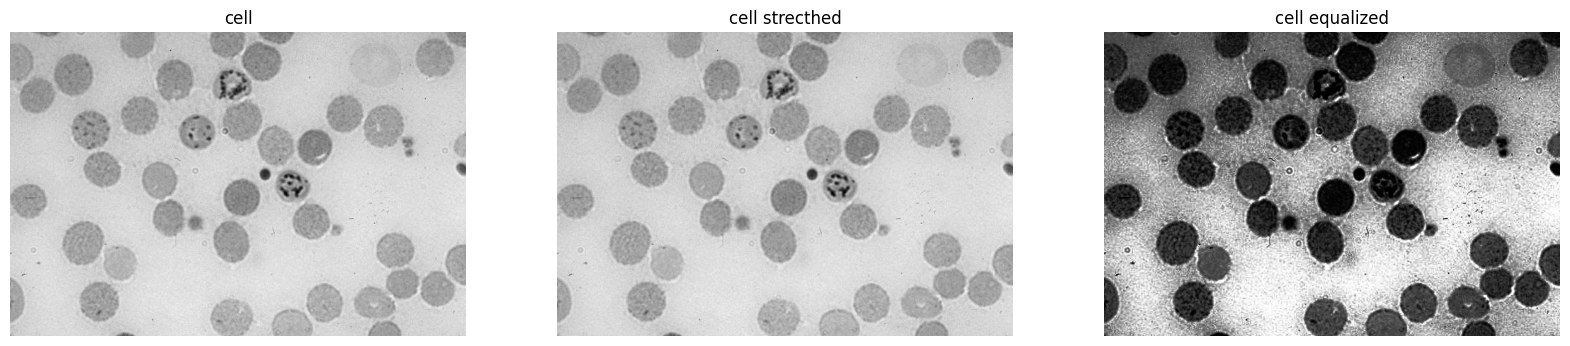

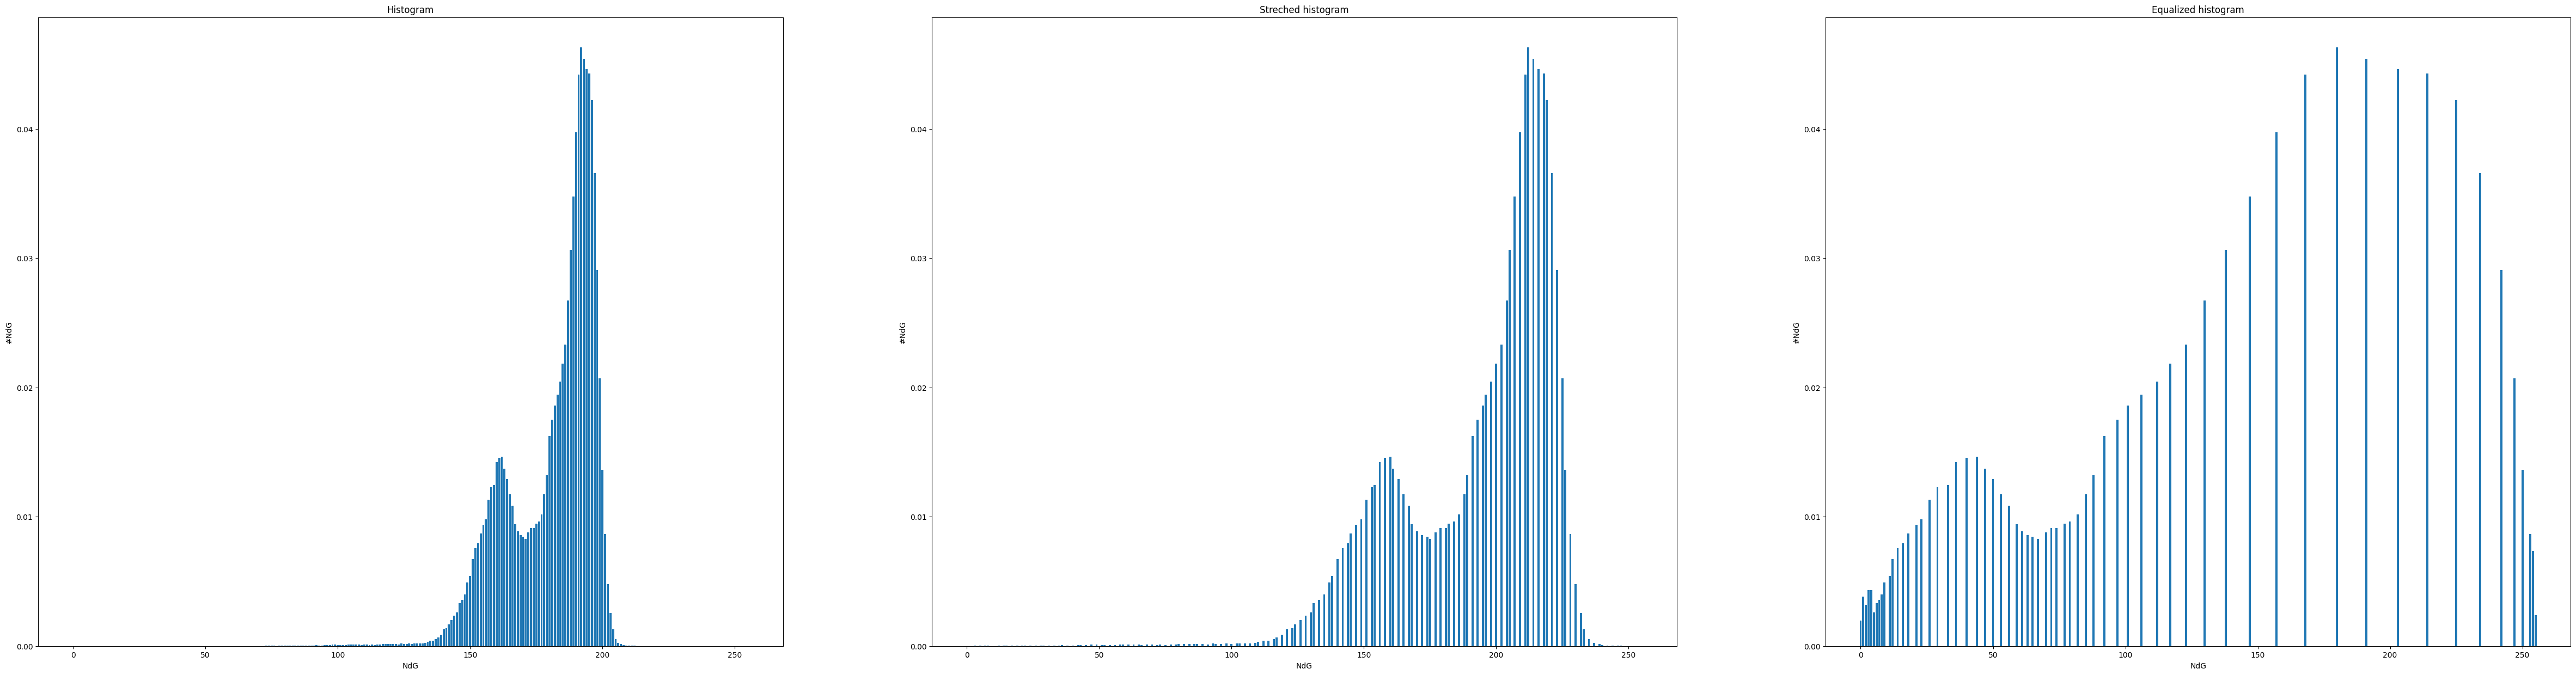

In [83]:
img_path = "img/cell.jpg"

# Loading Images
img = read_img(img_path)
str_img = hist_stretch(img)
equ_img = hist_equal(img)

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img, "cell")
plt.subplot(132), show_img(str_img, "cell strecthed")
plt.subplot(133), show_img(equ_img, "cell equalized")
plt.show()

# Plot the histograms
plt.figure(figsize=[60, 15])
plt.subplot(131), plot_hist(img, normal=True)
plt.subplot(132), plot_hist(str_img, normal=True, title="Streched histogram")
plt.subplot(133), plot_hist(equ_img, normal=True, title="Equalized histogram")
plt.show()

# Gamma Correction

In [84]:
def gamma_corr(img, gamma):
    return img**(1/gamma)

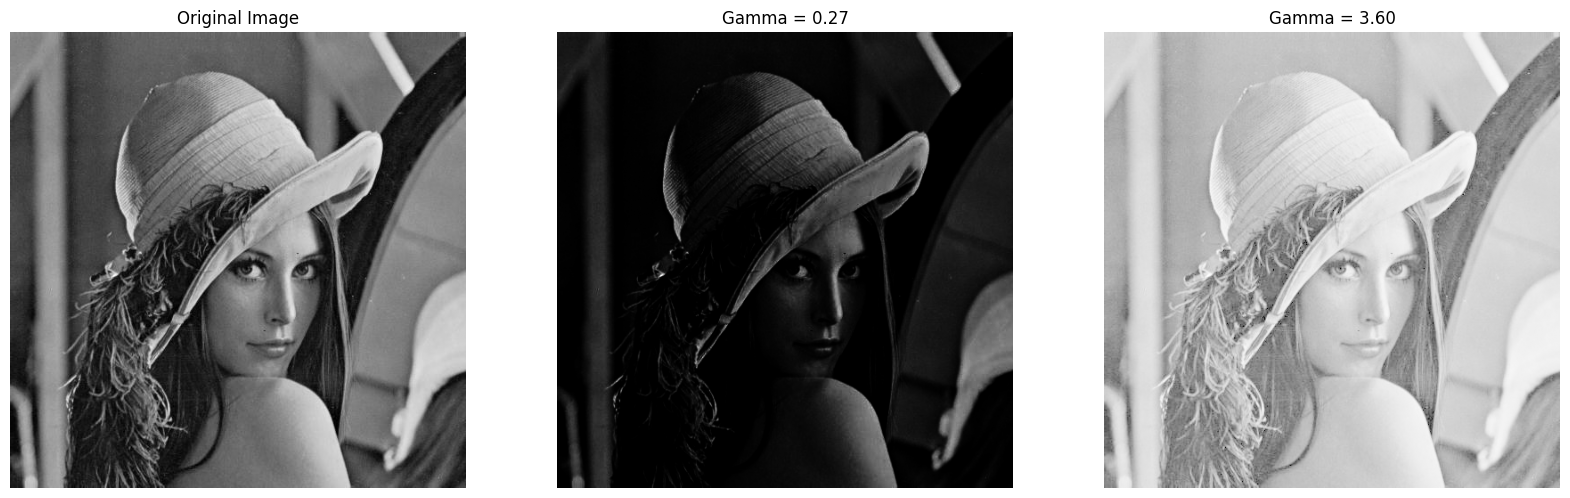

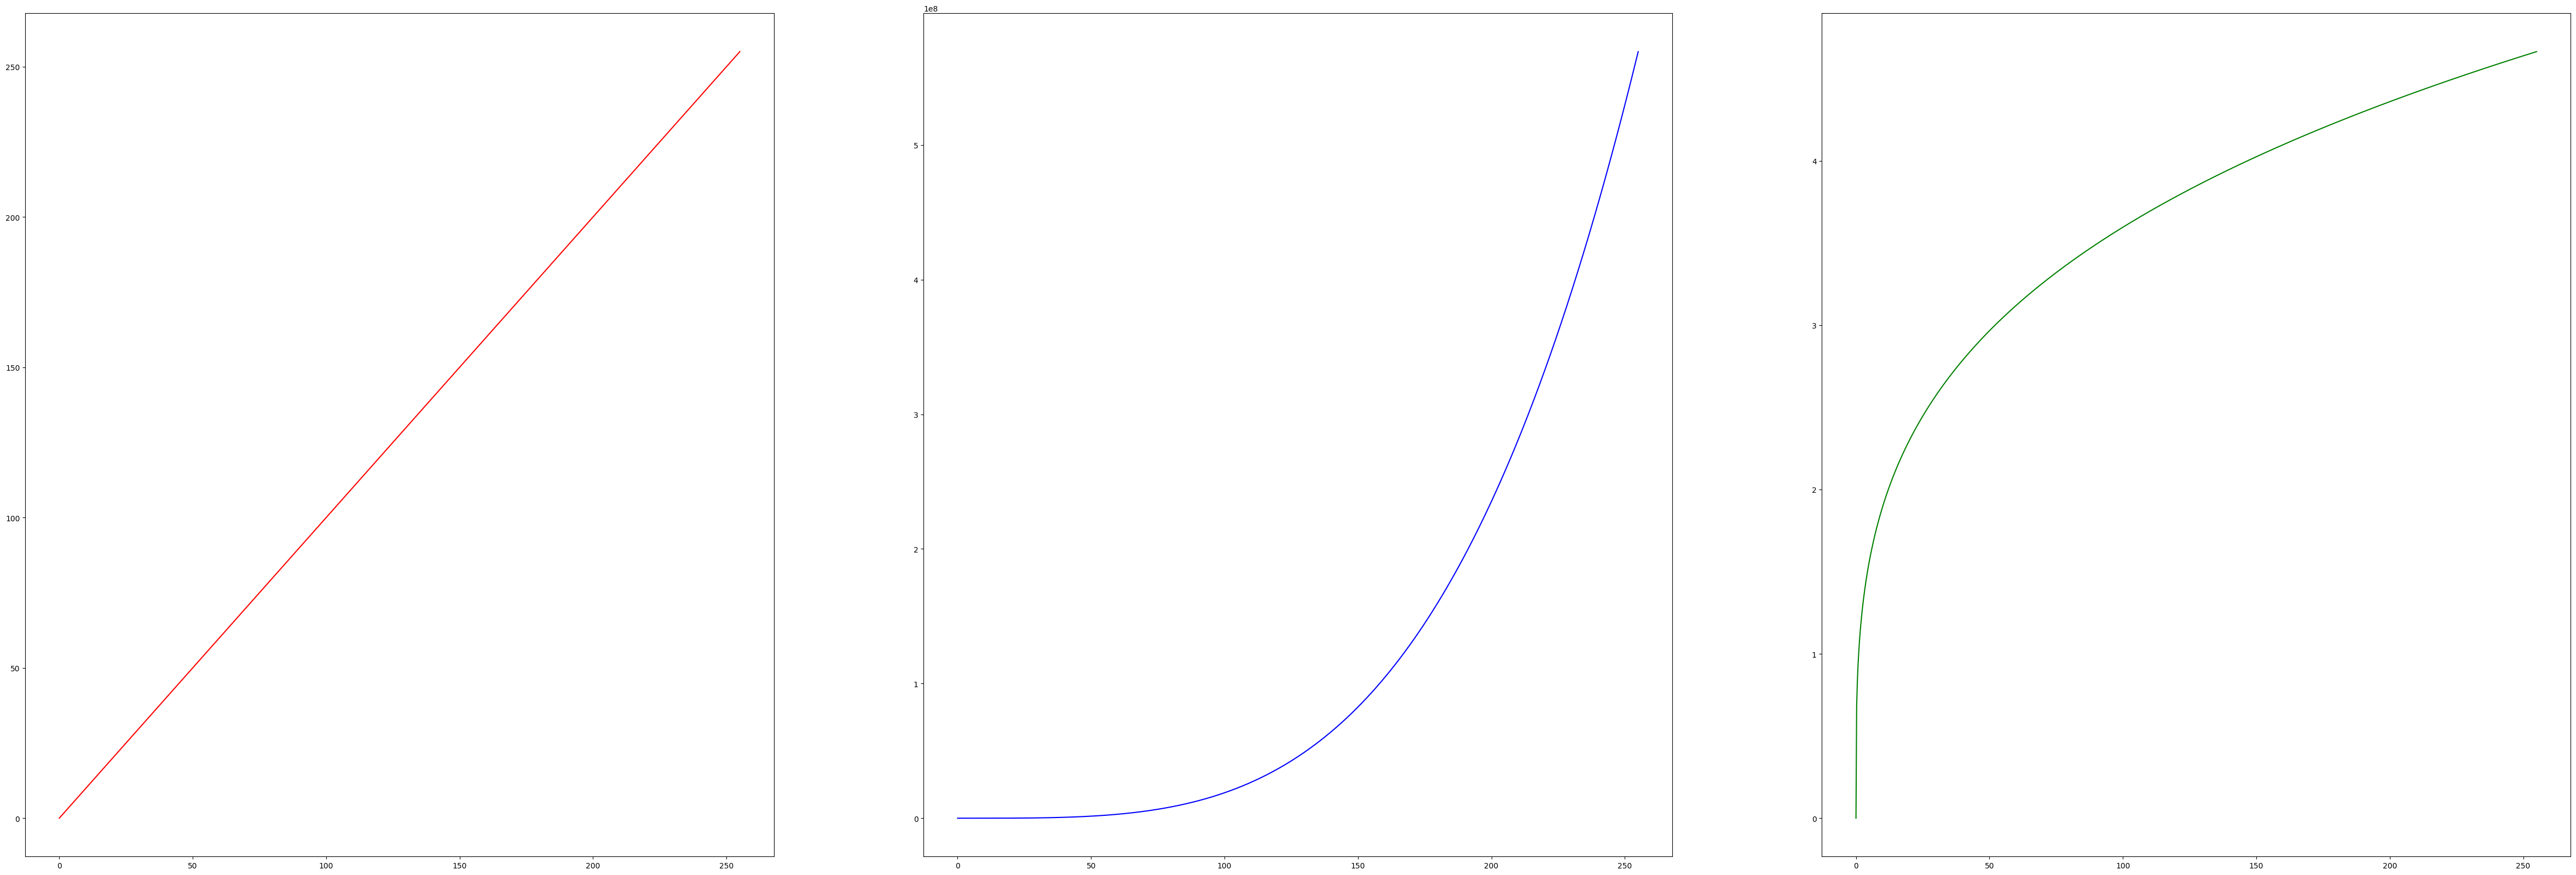

In [85]:
img_path = "img/lena1.jpg"
img = read_img(img_path)

gamma_1 = np.random.rand() 
if gamma_1 == 0:
    gamma_1 =0.4
gamma_2 = 1 + 5*np.random.rand()

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img)
plt.subplot(132), show_img(gamma_corr(img, gamma_1), f"Gamma = {gamma_1:.2f}")
plt.subplot(133), show_img(gamma_corr(img, gamma_2), f"Gamma = {gamma_2:.2f}")
plt.show()

# Plot the Gamma correction
x = np.linspace(0, 255, 1000)
plt.figure(figsize=[60, 20])
plt.subplot(131), plt.plot(x, x, 'r')
plt.subplot(132), plt.plot(x, x**(1/gamma_1), 'b')
plt.subplot(133), plt.plot(x, x**(1/gamma_2), 'g')
plt.show()

## Remarks:
    - The red curve corresond to gamma = 1 and it is the identity function
    - The blue curve corresponding to the 0 < gamma_1 < 1 is a convex function and it is under the red curve, that's why the images to which we've applied such a gamma value are darker (smaller intensity)
    - The green curve corresponding to the gamma_2 > 1 is a concave function and it is above the red curve, that's why the images to which we've applied such a gamma value are clearer (bigger intensity)

# Binarization

In [86]:
def otsu(img, trace=False):
    n = 256
    intra_std = np.ones(n)*np.inf
    for i in range(n):
        class_0 = img < i
        class_1 = img >= i

        std_0 = img[class_0].std() if np.any(class_0) else 0
        std_1 = img[class_1].std() if np.any(class_1) else 0

        w1, w2 = class_0.sum()/img.size, class_1.sum()/img.size  
        if trace:
            print(f"Threshold : {i}")
            print(f"std_0 : {std_0:.2f} | std_1 : {std_1:.2f}") 
            print(f"w_1 : {w1:.2f} | w_2 : {w2:.2f}") 
            print(f"intra_std : {w1*std_0 + w2*std_1:.2f}")
            print("_________")
        intra_std[i] = w1*std_0 + w2*std_1

    return intra_std.argmin()

In [ ]:
#print(otsu(img, trace=True))

Threshold : 0
std_0 : 0.00 | std_1 : 52.84
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.84
_________
Threshold : 1
std_0 : 0.00 | std_1 : 52.83
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.81
_________
Threshold : 2
std_0 : 0.48 | std_1 : 52.82
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.79
_________
Threshold : 3
std_0 : 0.87 | std_1 : 52.80
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.77
_________
Threshold : 4
std_0 : 1.19 | std_1 : 52.78
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.74
_________
Threshold : 5
std_0 : 1.49 | std_1 : 52.76
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.69
_________
Threshold : 6
std_0 : 1.75 | std_1 : 52.73
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.63
_________
Threshold : 7
std_0 : 1.98 | std_1 : 52.69
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.57
_________
Threshold : 8
std_0 : 2.21 | std_1 : 52.64
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.47
_________
Threshold : 9
std_0 : 2.40 | std_1 : 52.58
w_1 : 0.00 | w_2 : 1.00
intra_std : 52.35
_________
Threshold : 10
std_0 : 2.57 | std_1 : 52.50
w_1 : 

## Global Thresholding

In [88]:
def thresh(img, threshold=None):
    if threshold is None:
        threshold = otsu(img)
    else:
        assert 0 <= threshold <= 255\
        , "threshold must be in range(0,256)"    

    binary_img = np.zeros(shape=img.shape, dtype=np.uint8)    
    binary_img[img >= threshold] = 255
    return binary_img, threshold

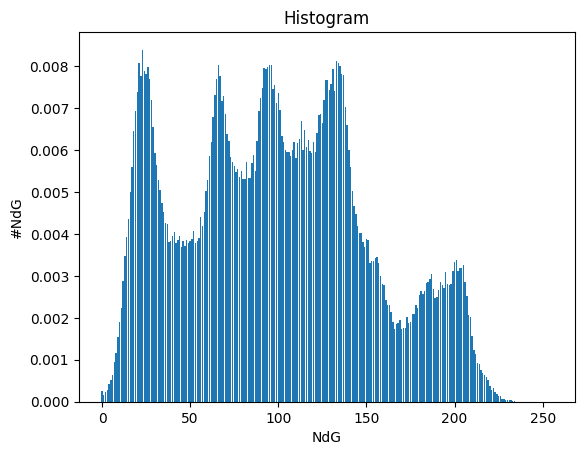

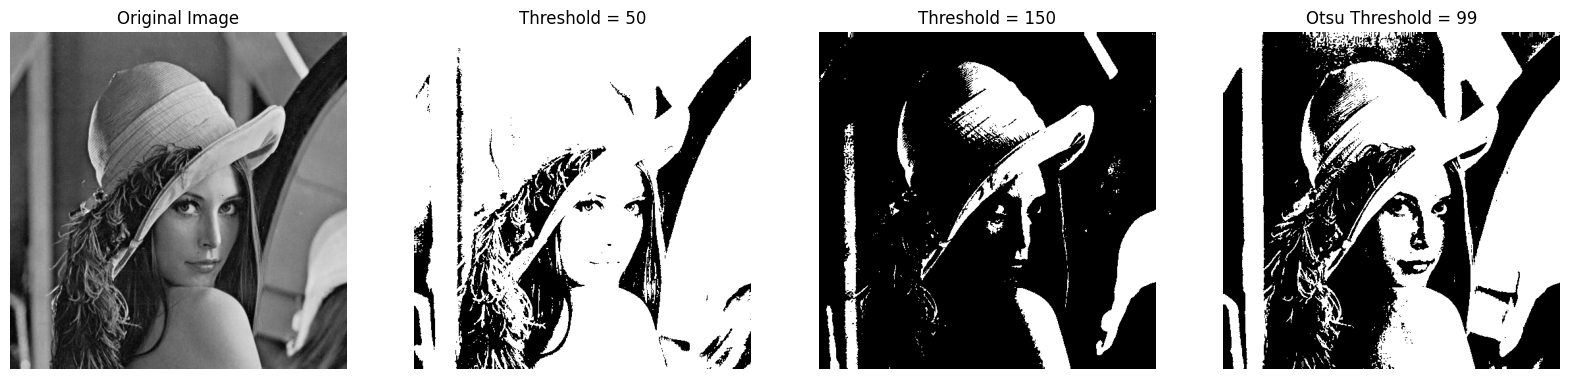

In [89]:
thresh_1 = 50
thresh_2 = 150

# Plot the histogram
plot_hist(img, True)

# Plot the images
plt.figure(figsize=[20, 80])
plt.subplot(141), show_img(img)
plt.subplot(142), show_img(thresh(img, thresh_1)[0], f"Threshold = {thresh_1}")
plt.subplot(143), show_img(thresh(img, thresh_2)[0], f"Threshold = {thresh_2}")
binary_img, otsu_ = thresh(img)
plt.subplot(144), show_img(binary_img, f"Otsu Threshold = {otsu_}")
plt.show()

## Local Thresholding

In [90]:
def subimages(img, n):
    r = int(np.floor(img.shape[0]/n))
    c = int(np.floor(img.shape[1]/n))
    subimages_ = [] 
    for i in range(n):
        for j in range(n):
            subimages_.append(img[r*i:r*(i+1), c*j:c*(j+1)])
    return subimages_    

In [91]:
def assemble_imgs(imgs, n):
    unit_r, unit_c = imgs[0].shape
    image = np.zeros(shape=(unit_r*n, unit_c*n), dtype=np.uint8)
    for i in range(n):
        for j in range(n):
            image[i*unit_r : (i+1)*unit_r, j*unit_c : (j+1)*unit_c] = imgs[i*n+j]
    return image 

In [92]:
def local_thresh(img, n):
    thresholds = []
    thresh_parts = []
    for img_ in subimages(img, n):
        img_, thresh_ = thresh(img_)
        thresh_parts.append(img_)
        thresholds.append(int(thresh_))
        #plt.figure(), show_img(img_), plt.show()

    return assemble_imgs(thresh_parts, n), np.array(thresholds)     

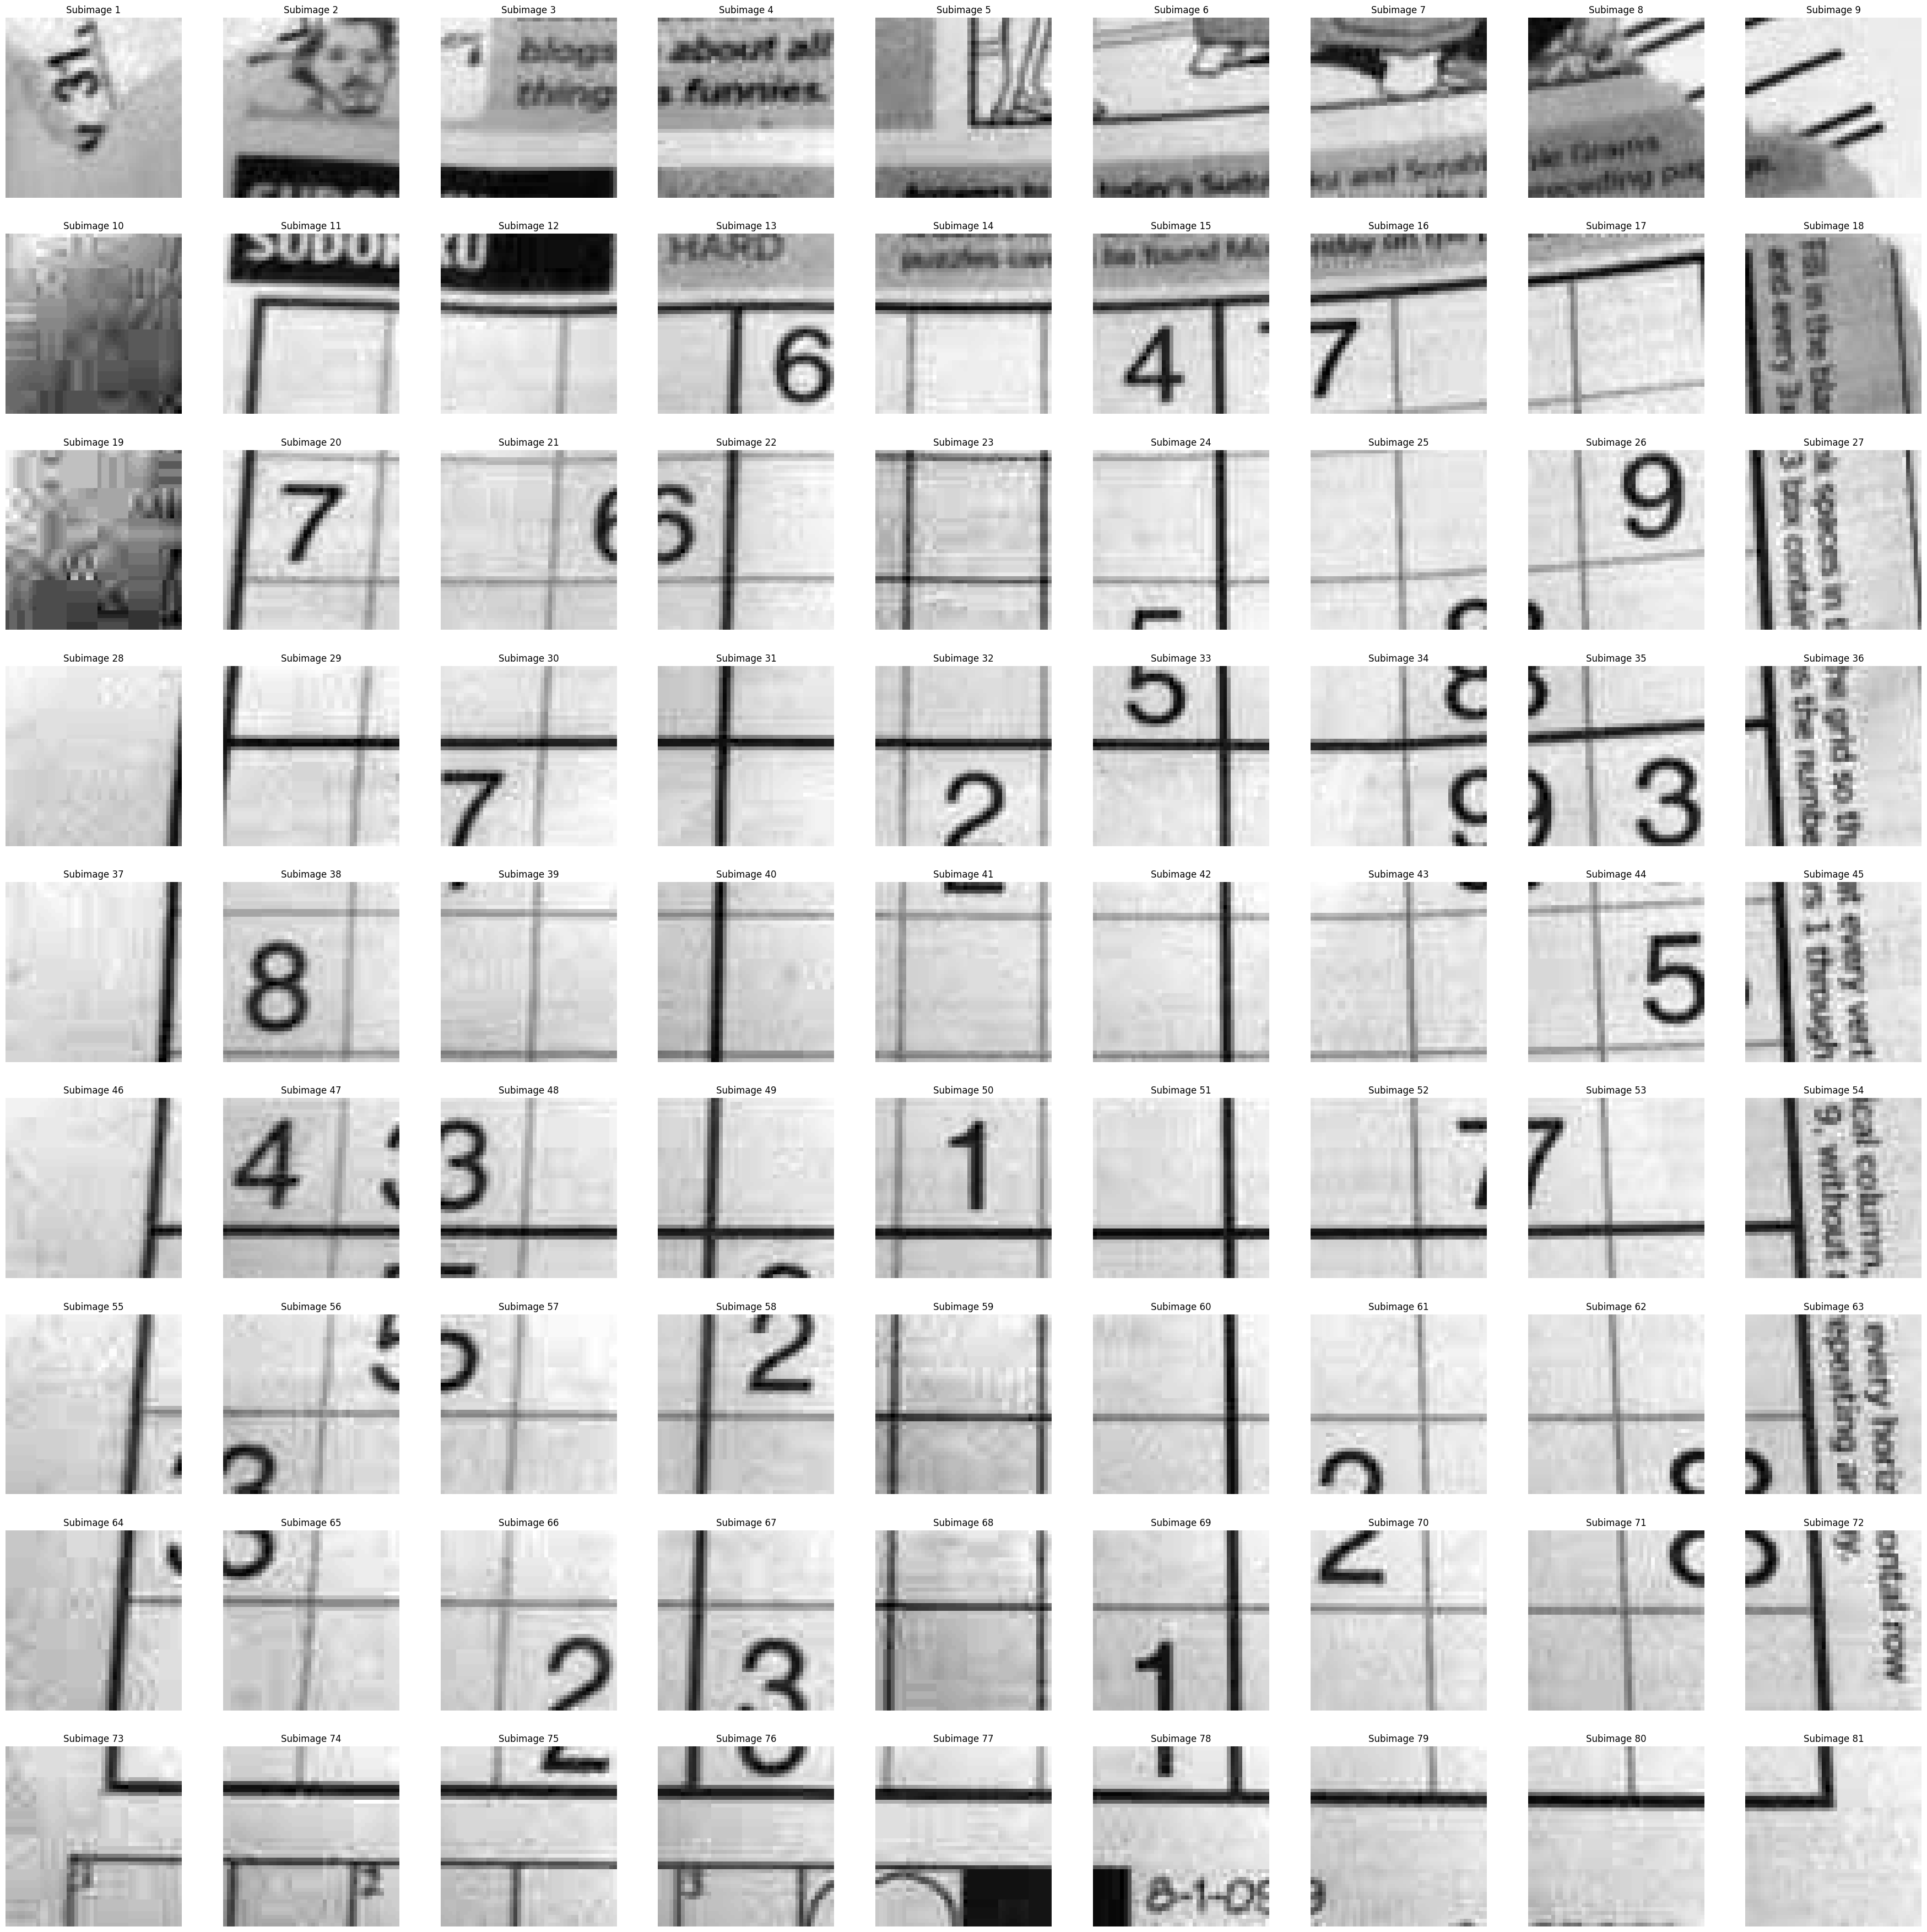

In [93]:
img_path = "img/sudoko.jpg"
img = read_img(img_path)

n = 9
s = subimages(img, n)

# Plot the images
plt.figure(figsize=[5*n, 5*n])
for i, img_ in enumerate(s):
    ax = plt.subplot(n, n, i+1)
    ax.imshow(img_, cmap='gray')
    ax.set_title(f"Subimage {i+1}")
    ax.axis('off')

plt.show()

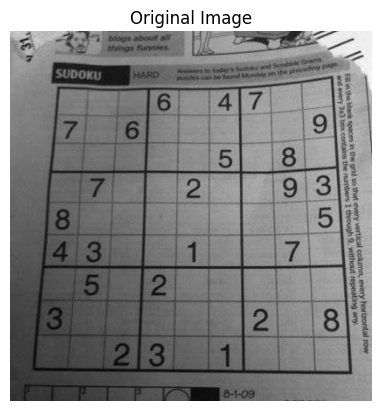

In [94]:
show_img(assemble_imgs(s, n))

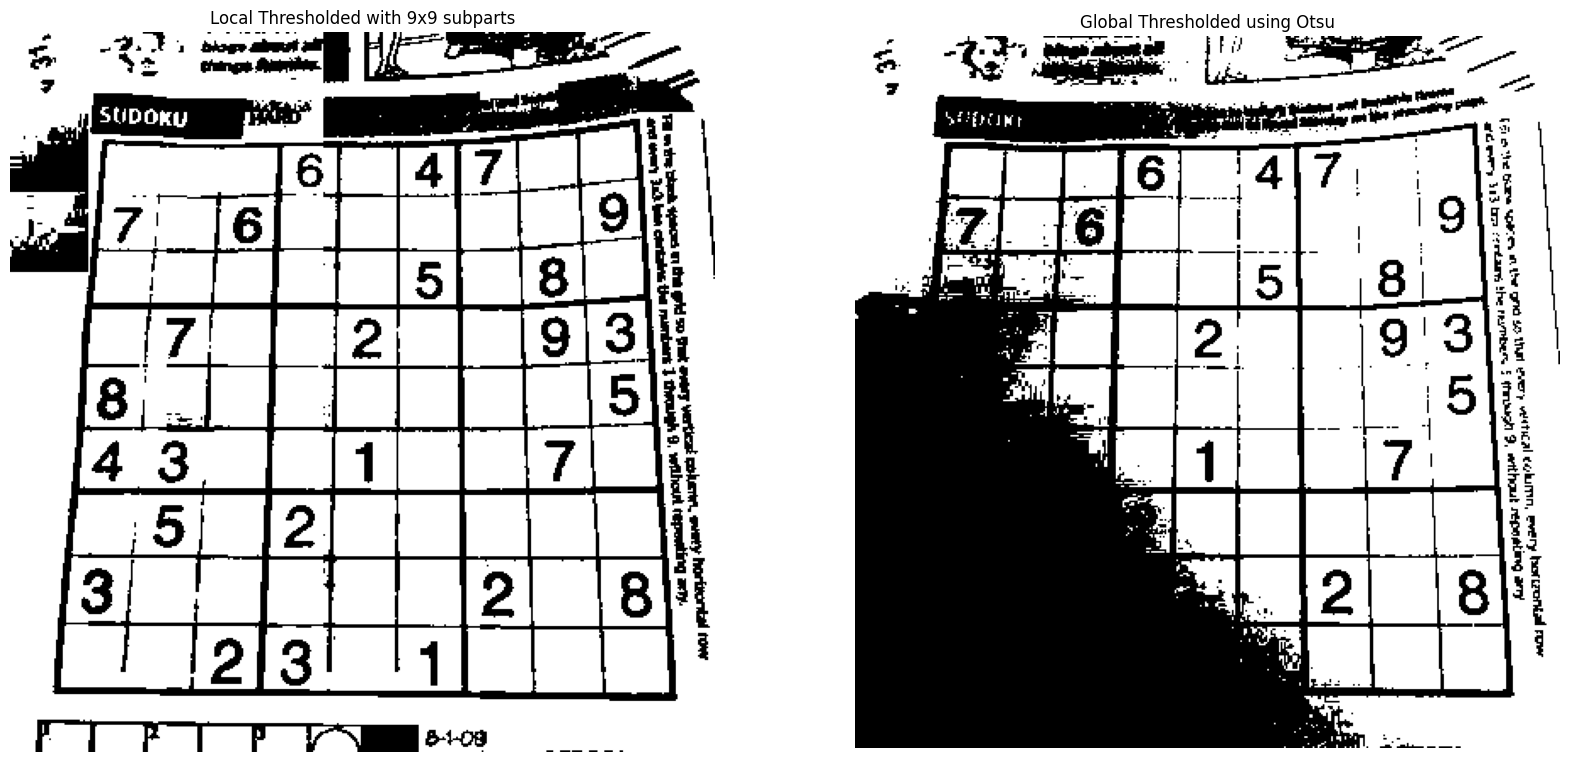

Global Thresholding : 98
_________
Local Thresholding : 
[[107  87  81  91 117 120 105 128 178]
 [119  81  71  78 109 111 121 129 119]
 [108  83  92  89 113 112 127 123 124]
 [ 79  78  82  88 103 105 114 114 124]
 [ 71  73  90  91 110 115 120 120 126]
 [ 61  59  67  76  91  86 107 115 119]
 [ 51  58  68  71  91  92 107 115 115]
 [ 45  55  60  65  79  78  96 106 110]
 [ 40  42  50  57  52  67  82  93 104]]


In [95]:
# Local Thresholding
lt = local_thresh(img, 9)

# Global Thresholding
gt = thresh(img)

# Plot the outut
plt.figure(figsize=[20, 40])
plt.subplot(121), show_img(lt[0], "Local Thresholded with 9x9 subparts")
plt.subplot(122), show_img(gt[0], "Global Thresholded using Otsu")
plt.show()

# Used thresholds
print(f"Global Thresholding : {gt[1]}")
print("_________")
print(f"Local Thresholding : \n{lt[1].reshape(9, 9)}")

# Smoothing and Cleaning Images

In [96]:
from scipy.signal import convolve2d

## Linear Filters

In [97]:
# Linear kernels:
def avg_kernel(n):
    assert n > 0, "n must be greather than 0"
    return np.ones(shape=(n, n))/(n**2)

def gaussian_kernel(n, sigma):
    assert n > 0, "n must be greather than 0"
    assert n % 2 == 1, "n must be odd"
    kernel = np.zeros((n, n), dtype=float)
    center = n // 2

    for i in range(n):
        for j in range(n):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)

    kernel /= kernel.sum()
    return kernel  

In [98]:
def gaussian_filter(img, n=3, sigma=1):
    kernel = gaussian_kernel(n, sigma)
    return convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)

def avg_filter(img, n=3):
    kernel = avg_kernel(n)
    return convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)

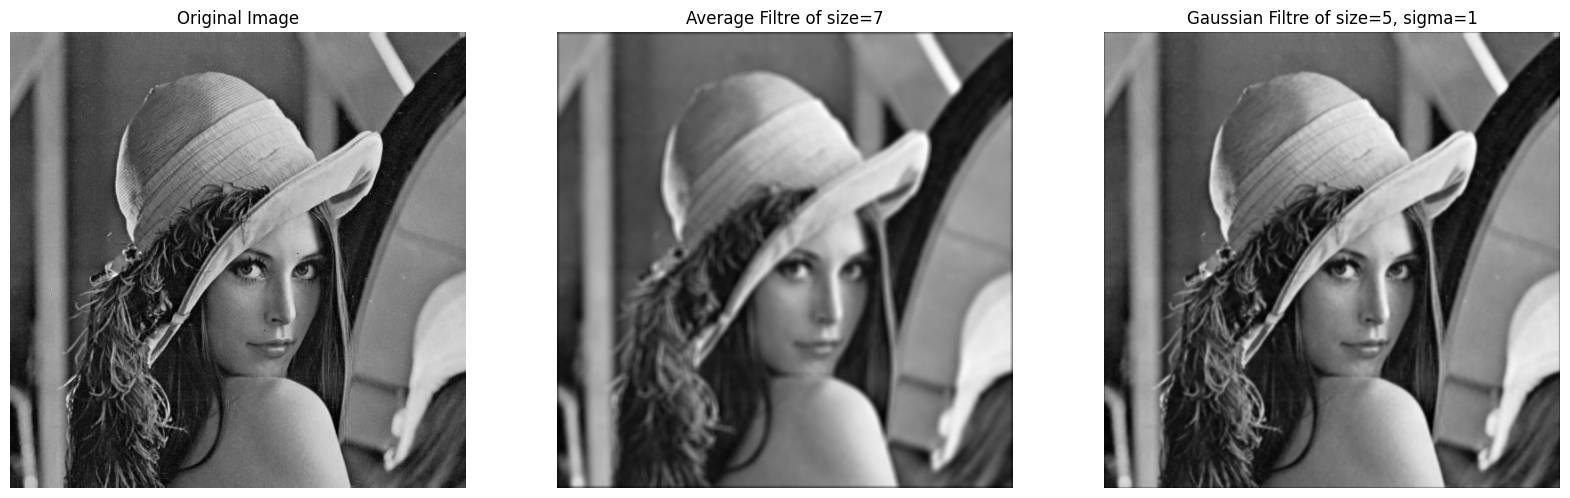

In [99]:
img_path = "img/lena1.jpg"
img = read_img(img_path)

size_avg = 7
size_gauss = 5
sigma = 1

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img)
plt.subplot(132), show_img(avg_filter(img, size_avg), f"Average Filtre of size={size_avg}")
plt.subplot(133), show_img(gaussian_filter(img, size_gauss), f"Gaussian Filtre of size={size_gauss}, sigma={sigma}")
plt.show()

## Median Filter

In [109]:
def median_filter(img, n=3):
    assert n > 0, "n must be greather than 0"
    assert n % 2 == 1, "n must be odd"

    r = n//2
    img_pad = np.pad(img, r, mode='constant', constant_values=0)
    median = np.zeros(shape=img.shape, dtype=img.dtype)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            patch = img_pad[i:i+n, j:j+n]
            median[i, j] = np.median(patch)
    return median

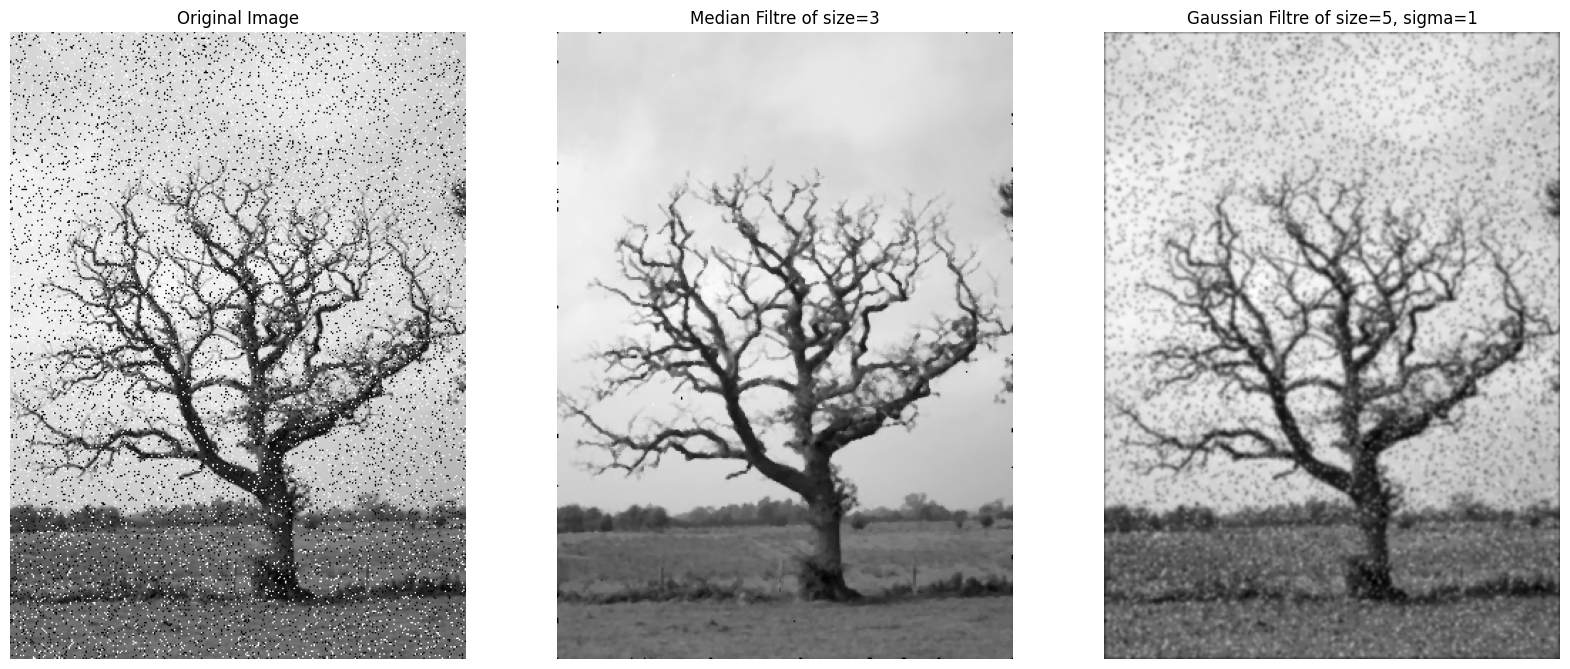

In [101]:
img_path = "img/Dead_tree_salt_and_pepper.png"
img = read_img(img_path)

size_med = 3
size_gauss = 5
sigma = 1

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img)
plt.subplot(132), show_img(median_filter(img, size_med), f"Median Filtre of size={size_med}")
plt.subplot(133), show_img(gaussian_filter(img, size_gauss), f"Gaussian Filtre of size={size_gauss}, sigma={sigma}")
plt.show()

# Edge detection

## Sobel

In [113]:
# 1D kernels
kernel_dx_1d = np.array([[-1, 0, 1]]) 
kernel_dy_1d = kernel_dx_1d.T
kernel_id_1d = np.ones(shape=(1, 3), dtype=np.uint8)

# Gaussian kernels ()
kernel_gauss_1d = np.array([[1, 2, 1]])
kernel_gauss_2d = kernel_gauss_1d.T @ kernel_gauss_1d/16

# 2D-gardient kernels
kernel_dx_2d = np.matmul(kernel_id_1d.T, kernel_dx_1d)
kernel_dy_2d = np.matmul(kernel_dy_1d, kernel_id_1d)

# 2D-sobel kernels
kernel_sobel_x = np.matmul(kernel_gauss_1d.T, kernel_dx_1d)
kernel_sobel_y = np.matmul(kernel_dy_1d, kernel_gauss_1d)

In [114]:
# Display multiple used kernel
print("Gaussian 2D (sigma=1) :")
print(kernel_gauss_2d)
print("_________")

print("Sobel in resect to (OX) axis :")
print(kernel_sobel_x)
print("_________")

print("Sobel in resect to (OY) axis :")
print(kernel_sobel_y)
print("_________")

Gaussian 2D (sigma=1) :
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
_________
Sobel in resect to (OX) axis :
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
_________
Sobel in resect to (OY) axis :
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
_________


In [1]:
def sobel_x(img):
    kernel = kernel_sobel_x
    return convolve2d(img, kernel, mode='same', boundary='fill')

def sobel_y(img):
    kernel = kernel_sobel_y
    return convolve2d(img, kernel, mode='same', boundary='fill')

def gradient(img):
    g_x, g_y = sobel_x(img), sobel_y(img)
    return np.sqrt(g_x**2 + g_y**2), np.atan(g_y/g_x)

def sobel(img, norm="L1"):
    assert norm=="L1" or norm=="L2", "norm must be L1 or L2"
    if norm=="L1":
        return np.abs(sobel_x(img)) + np.abs(sobel_y(img))
    else:
        return np.sqrt(sobel_x(img)**2 + sobel_y(img)**2)

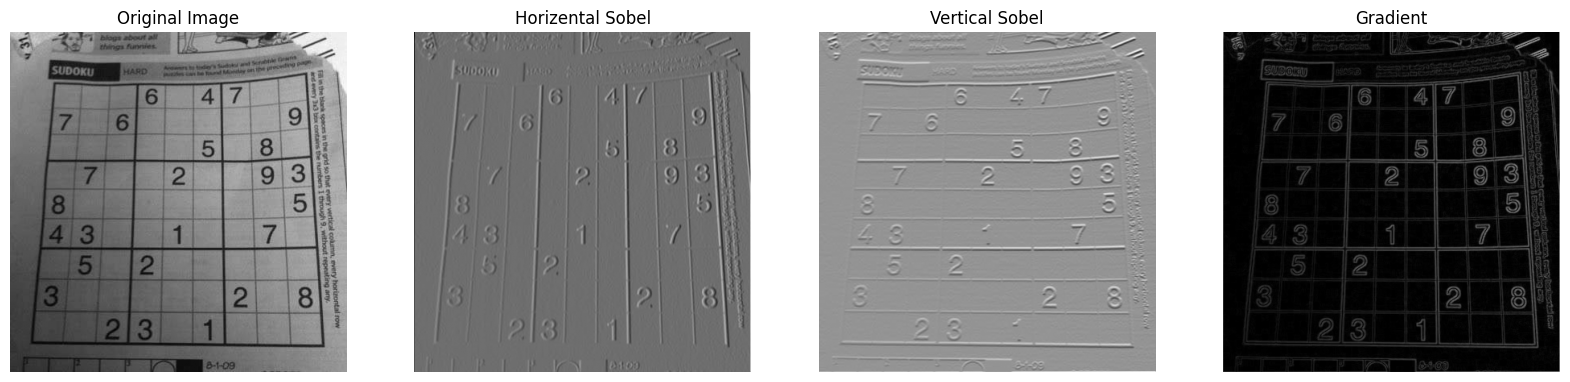

In [130]:
img_path = "img/sudoko.jpg"
img = read_img(img_path)

# Plot the images
plt.figure(figsize=[20, 80])
plt.subplot(141), show_img(img)
plt.subplot(142), show_img(sobel_x(img), "Horizental Sobel")
plt.subplot(143), show_img(sobel_y(img), "Vertical Sobel")
plt.subplot(144), show_img(sobel(img, "L1"), "Gradient")
plt.show()

## DoG

# Laplacian